# SI 618: Data Manipulation and Analysis
## 05 - Data analysis: ANOVA, t-test, linear models

### Dr. Chris Teplovs, School of Information, University of Michigan
<small><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a> This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


## Overview

* questions/comments/concerns
  * pace/workload
* homework review
* distributions
* visualization theory
* t-tests
* regression
* ANOVA

## Why do we care about distributions?
## World is not normal
* Many other kinds of distributions
* We can tell what they are by looking at distribution

## Uniform

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

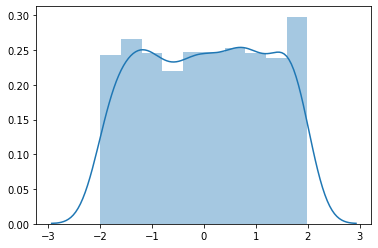

In [5]:
uniform = np.random.uniform(-2,2,1000)  # low,high,count
sns.distplot(uniform,kde=False,norm_hist=False)
# sns.distplot(uniform,kde=True,norm_hist=False) usually, keep kde off

## Bimodal

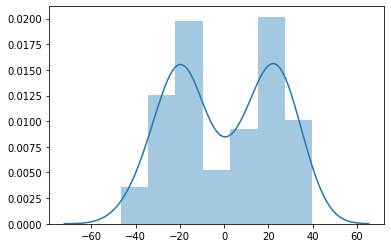

In [7]:
bimodal = np.append(np.random.normal(-20,10,100),
                    np.random.normal(20,10,100))
# sns.distplot(bimodal,kde=False,norm_hist=True)
sns.distplot(bimodal,kde=True,norm_hist=True) #sometimes you want kde on

# Poisson

$$ P(k~events~in~interval) = \frac{\lambda^ke^{-\lambda}}{k!} $$

$\lambda$ is the event rate

Examples
* Meteor strikes
* Arrival of patients to hospital

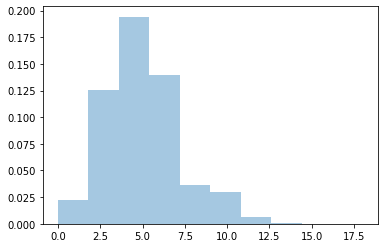

In [11]:
# as lambda goes up --> looks more normal
pois = np.random.poisson(5,100000) # lambda, count 
# if the first value of poisson big, it will look more like a normal distribution, try from 1 to 5, when it's small, it looks like half normal distribution
sns.distplot(pois,kde=False,bins=10,norm_hist=True)

# Power/Zipf/Pareto

$$ P = \frac{x^{-a}}{\zeta(a)}$$

"long tail"
* degree distribution
* movie/music popularity
* words


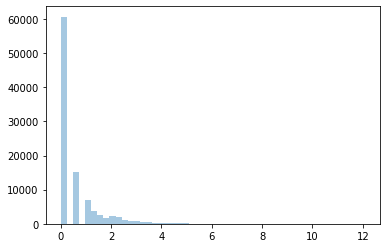

In [12]:
power = np.random.zipf(2,100000)
sns.distplot(np.log(power),kde=False)

## Visual Tests on Data

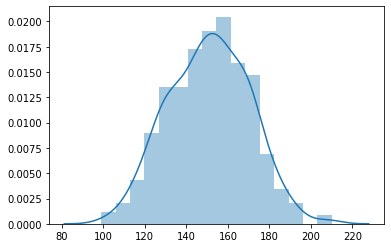

In [13]:
testdata = (np.random.standard_normal(500)*20+150).astype(int)
sns.distplot(testdata)

## Run Sequence
* Run Sequence (index versus value)
* flat and non-drifting
 * fixed-location assumption holds
* vertical spread same over the entire plot, 
 * then the fixed-variation assumption holds.

Text(0.5, 0, 'i')

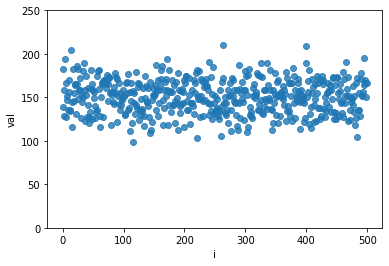

In [14]:
ax = sns.regplot(np.arange(len(testdata)),testdata,fit_reg=False)
ax.set_ylim(0,250)
ax.set_ylabel("val")
ax.set_xlabel("i") 
# it's flat, a little more dense in the middle and spread with Y axis, but flat overall

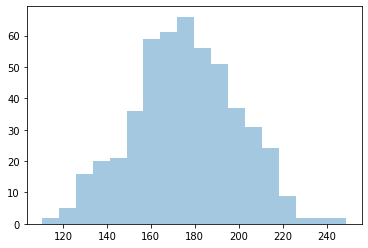

In [15]:
drifting = np.array([testdata[i]+i*(.1) for i in np.arange(len(testdata))])
sns.distplot(drifting,kde=False)

Text(0.5, 0, 'i')

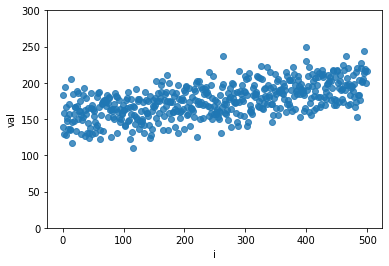

In [16]:
ax = sns.regplot(np.arange(len(drifting)),drifting,fit_reg=False)
ax.set_ylim(0,300)
ax.set_ylabel("val")
ax.set_xlabel("i")

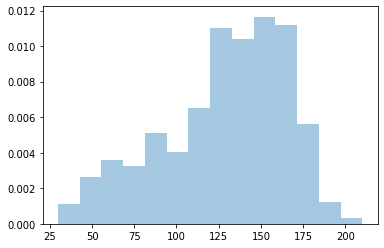

In [17]:
expanding = np.array([(testdata[i]+i*np.random.randint(-1,1)*.2)
                     for i in np.arange(len(testdata))])
sns.distplot(expanding,kde=False,norm_hist=True)

Text(0.5, 0, 'i')

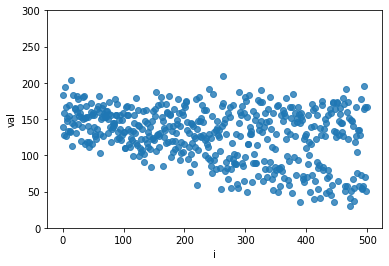

In [18]:
ax = sns.regplot(np.arange(len(expanding)),expanding,fit_reg=False)
ax.set_ylim(0,300)
ax.set_ylabel("val")
ax.set_xlabel("i")

# Lag Plot

* Plot point $y_i$ versus $y_{i-1}$
* If the lag plot is structureless
 * randomness assumption holds.

Text(0.5, 0, 'y_i')

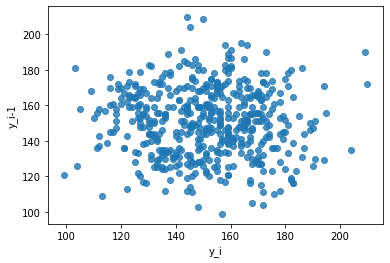

In [19]:
lag = testdata.copy()
lag = np.array(lag[:-1])
current = testdata[1:]
ax = sns.regplot(current,lag,fit_reg=False)
ax.set_ylabel("y_i-1")
ax.set_xlabel("y_i")
# this is the by defaul how normal distribution look like

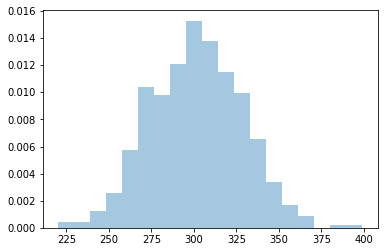

In [20]:
connected = np.array([testdata[i]+testdata[i-1] for i in np.arange(500)])
sns.distplot(connected,kde=False,norm_hist=True)

Text(0.5, 0, 'y_i')

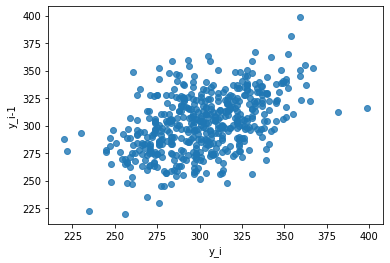

In [21]:
lag = connected.copy()
lag = np.array(lag[:-1])
current = connected[1:]
ax = sns.regplot(current,lag,fit_reg=False)
ax.set_ylabel("y_i-1")
ax.set_xlabel("y_i")

## QQ Plot
* QQ Plots takes our n ordered data points
 * sorted from smallest to largest
* Asks:
 * What is the relationship between quantiles from our data and quantiles from a theoretical distribution that we're assuming the sample is drawn from

In [25]:
import scipy.stats as stats

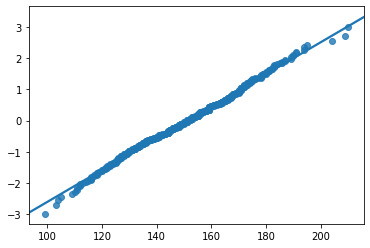

In [26]:
qntls, xr = stats.probplot(testdata, fit=False)
sns.regplot(xr,qntls)
# this is normal distribution coz the line is not turning to certain direction

In [27]:
def random_snorm(n, mean = 0, sd = 1, xi = 1.5):
    def random_snorm_aux(n, xi):
        weight = xi/(xi + 1/xi)
        z = np.random.uniform(-weight,1-weight,n)
        xi_ = xi**np.sign(z)
        random = -np.absolute(np.random.normal(0,1,n))/xi_ * np.sign(z)
        m1 = 2/np.sqrt(2 * np.pi)
        mu = m1 * (xi - 1/xi)
        sigma = np.sqrt((1 - m1**2) * (xi**2 + 1/xi**2) + 2 * m1**2 - 1)
        return (random - mu)/sigma

    return random_snorm_aux(n, xi) * sd + mean


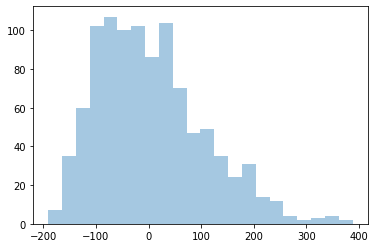

In [28]:
rightskewed = random_snorm(1000,xi=2)*100
sns.distplot(rightskewed,kde=False)

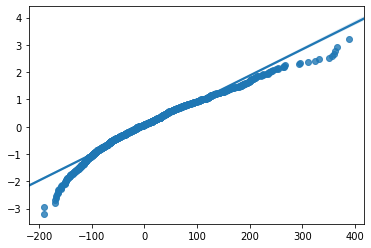

In [29]:
qntls, xr = stats.probplot(rightskewed, fit=False)
sns.regplot(xr,qntls)
# this line shows the distribution skewed to the right

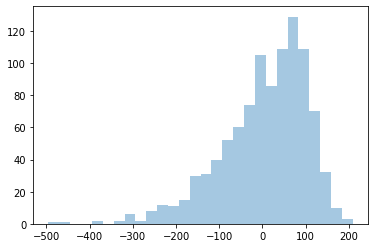

In [30]:
leftskewed = random_snorm(1000,xi=-2)*100
sns.distplot(leftskewed,kde=False)

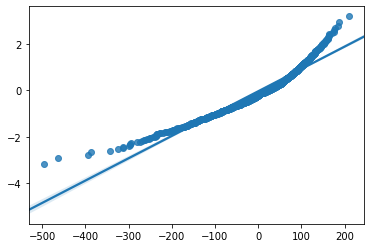

In [31]:
qntls, xr = stats.probplot(leftskewed, fit=False)
sns.regplot(xr,qntls)
# this line shows the distribution skewed to the left

## Now the serious plots... let's wrap them in a single function that we can call

In [46]:
def multiplePlots( series,name ):
    
    fig, axs = plt.subplots(2,2)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)
    plt.annotate(name,xy=(0,0))

    # Histogram
    sns.distplot(series, ax=axs[0,0])
    
    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(current,lag,fit_reg=False, ax=axs[0,1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")
    
    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(xr,qntls, ax=axs[1,0])
    
    # Run sequence
    ax = sns.regplot(np.arange(len(series)),series, ax=axs[1,1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")


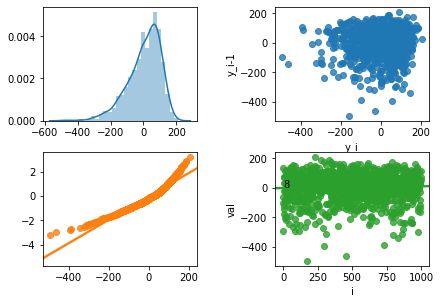

In [48]:
multiplePlots(leftskewed,v)

### <font color="magenta">Group Question (Q0): </font>
The sample.csv file, included with today's lab, contains 9 variables (v0 through v9) that contain
measures drawn from different distributions.
Your task is to use the investigative techniques we discussed in today's lab to determine
what type of distribution the sample is drawn from.

You should first load the CSV file into a DataFrame, then look at various aspects of **each** variable.

**Your responses should consist of code cells, as well as markdown cells that state something like:**
> Variable v99 appears to be drawn from a uniform distribution with mean X and standard deviation Y.  
> A histogram of the data appears to be...
> The QQ plot shows.... 


In [49]:
sample = pd.read_csv('data/sample.csv')
sample.describe()

,Unnamed: 0,v0,v1,v2,v3,v4,v5,v6,v7,v8
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,249.500000,0.048769,1.025355,-4.530455,1.604000,30.768000,2.082000,148.182000,-0.390372,198.792000
std,144.481833,1.168859,104.943593,101.424790,2.766675,20.301687,1.341221,19.523093,22.506730,34.577506
min,0.000000,-1.998116,-188.691985,-376.499646,1.000000,-34.000000,0.000000,94.000000,-47.573673,106.000000
25%,124.750000,-0.918946,-78.735102,-61.984783,1.000000,17.000000,1.000000,134.000000,-21.067972,174.750000
50%,249.500000,0.166880,-16.207729,13.614648,1.000000,31.000000,2.000000,147.000000,-1.304978,197.000000
75%,374.250000,1.054630,61.301734,75.711610,1.000000,43.000000,3.000000,161.000000,20.397352,225.150000
max,499.000000,1.996645,385.891667,151.545441,38.000000,91.000000,6.000000,216.000000,42.922994,286.800000


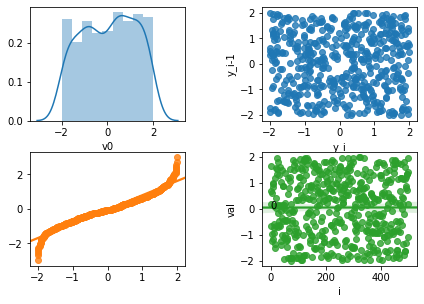

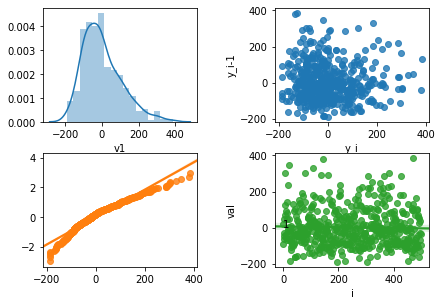

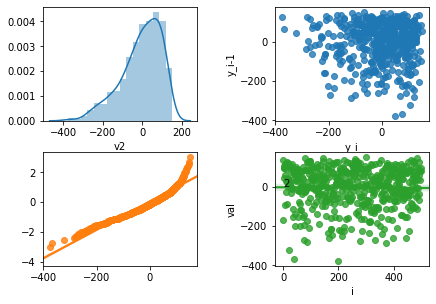

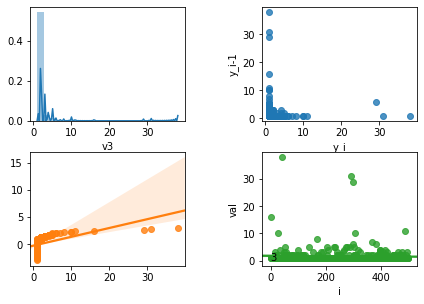

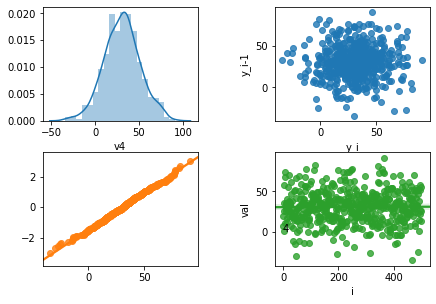

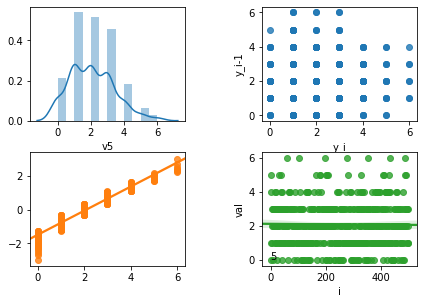

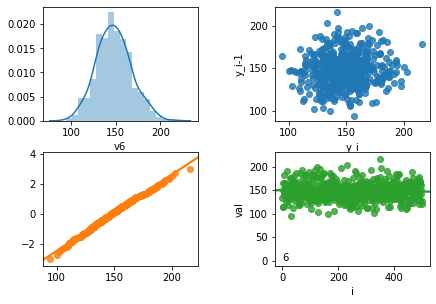

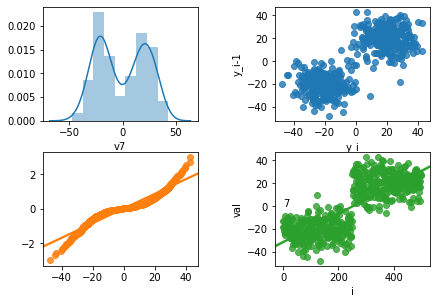

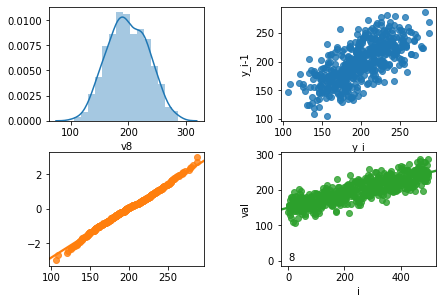

In [50]:
for v in range(9):
    multiplePlots(sample['v'+str(v)],v)

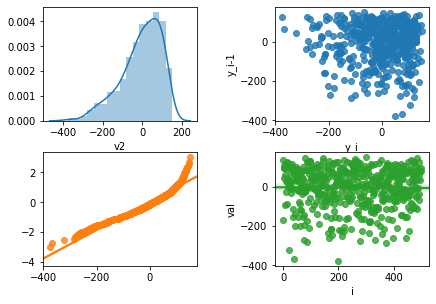

In [43]:
multiplePlots(sample.v2) # we are group 3

new word: kurtosis, shows how wide/flat of sharp (peaky) the middle distribution

v8: 
    orange chart: below the line is under represented, if it's above the line, it's over represented 
    
v7:
    got 2 clusters in lag and run sequence charts, bimodel histgram distribution
    
v5:
    poison distribution histogram
    
v3:
    power distribution 
    
v2:
    from histgram and qq charts, it's left skewed, the lag plot is the order of values given to you. the green chart: it's denser on the top. 
    
v0:
    uniformed distribution
    
always describe data, then multiple charts to visualize

## Visualization for Data Scientists

We're going to ask a special virtual guest lecturer to provide some background on data visualization.  Together, we'll watch [a brief (8-minute video) by Dr. Chris Brooks](
https://www.coursera.org/learn/python-plotting/lecture/qrqqa/tools-for-thinking-about-design-alberto-cairo)
and pause it several times to answer the following questions:



## <font color="magenta">Q1a: As someone who is studying data science, who are you trying to reach through your visualizations?  </font>


To my boss (who more focus on business side) or my clients (who mostly have business needs and have non-tech background).

I must also be able to communicate complex ideas to your nontechnical stakeholders in a way they can easily understand. Data-science software tools can help me visualize my findings, but I will also need the verbal communication skills to tell the story clearly.

## <font color="magenta">Q1b: What sense can you make of this image?</font>
![](resources/BrooksResearch.png)


There are multiple demensions on X and Y axis. It can be seen that students who has poor performance (below 60%) are more clustered in the group of less-50% chapters accessed, whereas the good-performed students are more clustered in the  group of above-50% chapters accessed. The 2 red lines sectioned the point chart very well, that we can clearly see different groups of students performance vs percentage of chapters accessed. 

One interesting point is the right-bottom section shows there are students accessing more chapters while still having poor performance, I think that might because they just access the chapter but not actually learning the chapters comparing with the students in the right-top section.

## <font color="magenta">Q1c: How many different kinds of information can you see in the Minard graphic, and what are they?</font>

![](resources/Menard.png)

A thick band illustrates the size of his army at specific geographic points during their advance and retreat. It displays six types of data in two dimensions: the number of Napoleon's troops; the distance traveled; temperature; latitude and longitude; direction of travel; and location relative to specific dates without making mention of Napoleon; Minard's interest lay with the travails and sacrifices of the soldiers.

source:https://en.wikipedia.org/wiki/Charles_Joseph_Minard


## Returning to Seaborn: 

https://seaborn.pydata.org/examples/index.html

Take a look at the different visualizations that are possible.

## <font color="magenta">Q2a: Provide the title, description, and URL of one of the visualizations that you find particularly interesting and explain why you find it interesting.  </font>

title: Scatterplot with categorical and numerical semantics

description: there's no variable summaries or instructions for the chart, so I don't know what's it about, but I know it's a scatter plot showing relationship between carat (categorical value) and price (numeric value) in terms of darity (by color) and depth (by size of the point).

url: https://seaborn.pydata.org/examples/different_scatter_variables.html

the distribution of the points is interesting, showing a very clear sections in a few different carat groups. 


## <font color="magenta">Q2b: Given what we learned from Prof. Brooks, indicate 1-3 axes from Cairo's Visual Wheel where your chosen Seaborn visualization would likely score highly. Explain why.</font>

![](resources/CairoVisualWheel.png)

It has good Density, the density of points is very distinguish from different carats.
It has good Multidimensionality, it has 4 dimensions without confusing readers.
I'm sure the chart can convey more information if it has more verbal illustrations of the information background. 

## Seaborn versus Matplotlib
* Matplotlib
     * Low-level, basis for many packages
     * Painful to construct certain graphs
     * Not Pandas friendly
     * Not interactive
* Seaborn
     * Pandas friendlier
     * Great for some stats plots


## Part 1: Iris dataset
![](resources/iris.png)

In [ ]:
import seaborn as sns

In [ ]:
df = sns.load_dataset('iris')
df.head()

Remember our distplots:


In [ ]:
sns.distplot(df.sepal_length)

## <font color="magenta"> Q3: Create similar plots for the other three numeric variables in the dataset. In a couple of sentences, describe each of the plots.  </font>

In [ ]:
# insert your code here

Insert your interpretation here

We often want to see how variables vary with each other.  In seaborn, we do this using 
the jointplot(). So, for example, if we wanted to look at the relationship between the
distributions of sepal_length and sepal_width, we could do something like:

In [ ]:
sns.jointplot(x='sepal_length',y='sepal_width',data=df)

## <font color="magenta"> Q4: It's a bit difficult to see where the interesting areas in the plot are, so it's worth trying a hexbin plot.  Go ahead and copy the above  code block and add ```kind="hex"``` to the jointplot parameters. In a couple of sentences, describe what stands out to you about the visualization. </font>

In [ ]:
# insert your code here

Insert your interpretation here

Now, take a look at what happens when you set ```kind="kde"```

In [ ]:
sns.jointplot(x='sepal_length',y='sepal_width',data=df,kind="kde")

Finally, you may want to look at all the numeric variables in your
dataset. Use ```pairplot``` to do this:


In [ ]:
sns.pairplot(df.query("species == 'setosa'"))

We can get fancier by using a different column to set the color (or "hue"):

Try running the following code:

In [ ]:
sns.pairplot(df,hue="species")

Now let's introduce some correlations.  We're not going to spend time on learning about the 
theory behind correlation, as you've done that in the statistics prerequisite for this course.
Instead, we're going to jump right in and annotate a graph with a lot of statistical information:

In [ ]:
from scipy import stats

In [ ]:
# ignore the warning about deprecated annotation
g = sns.JointGrid(data=df,x='petal_length',y='sepal_length')
g = g.plot(sns.regplot, sns.distplot)
g = g.annotate(stats.pearsonr)

Think about what the different components mean.  We'll return to using this in the next section on Wine Quality.

## Part 2: Wine quality (again)
![](resources/vinho.png)
https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009/home

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np

In [52]:
wine = pd.read_csv('data/winequality-red.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [53]:
wine['isgood'] = np.where(wine['quality'] > 5, 'good','bad')

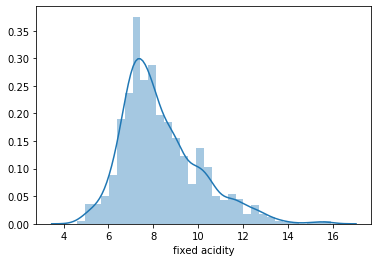

In [54]:
# Note the following notation
sns.distplot(wine[('fixed acidity')])

## <font color="magenta">Q5: (Homework Review) Create a pairplot for the wine dataset that plots 'good' and 'bad' wines in different hues. In a couple of sentences, describe interesting relationships shown by the visualization.  

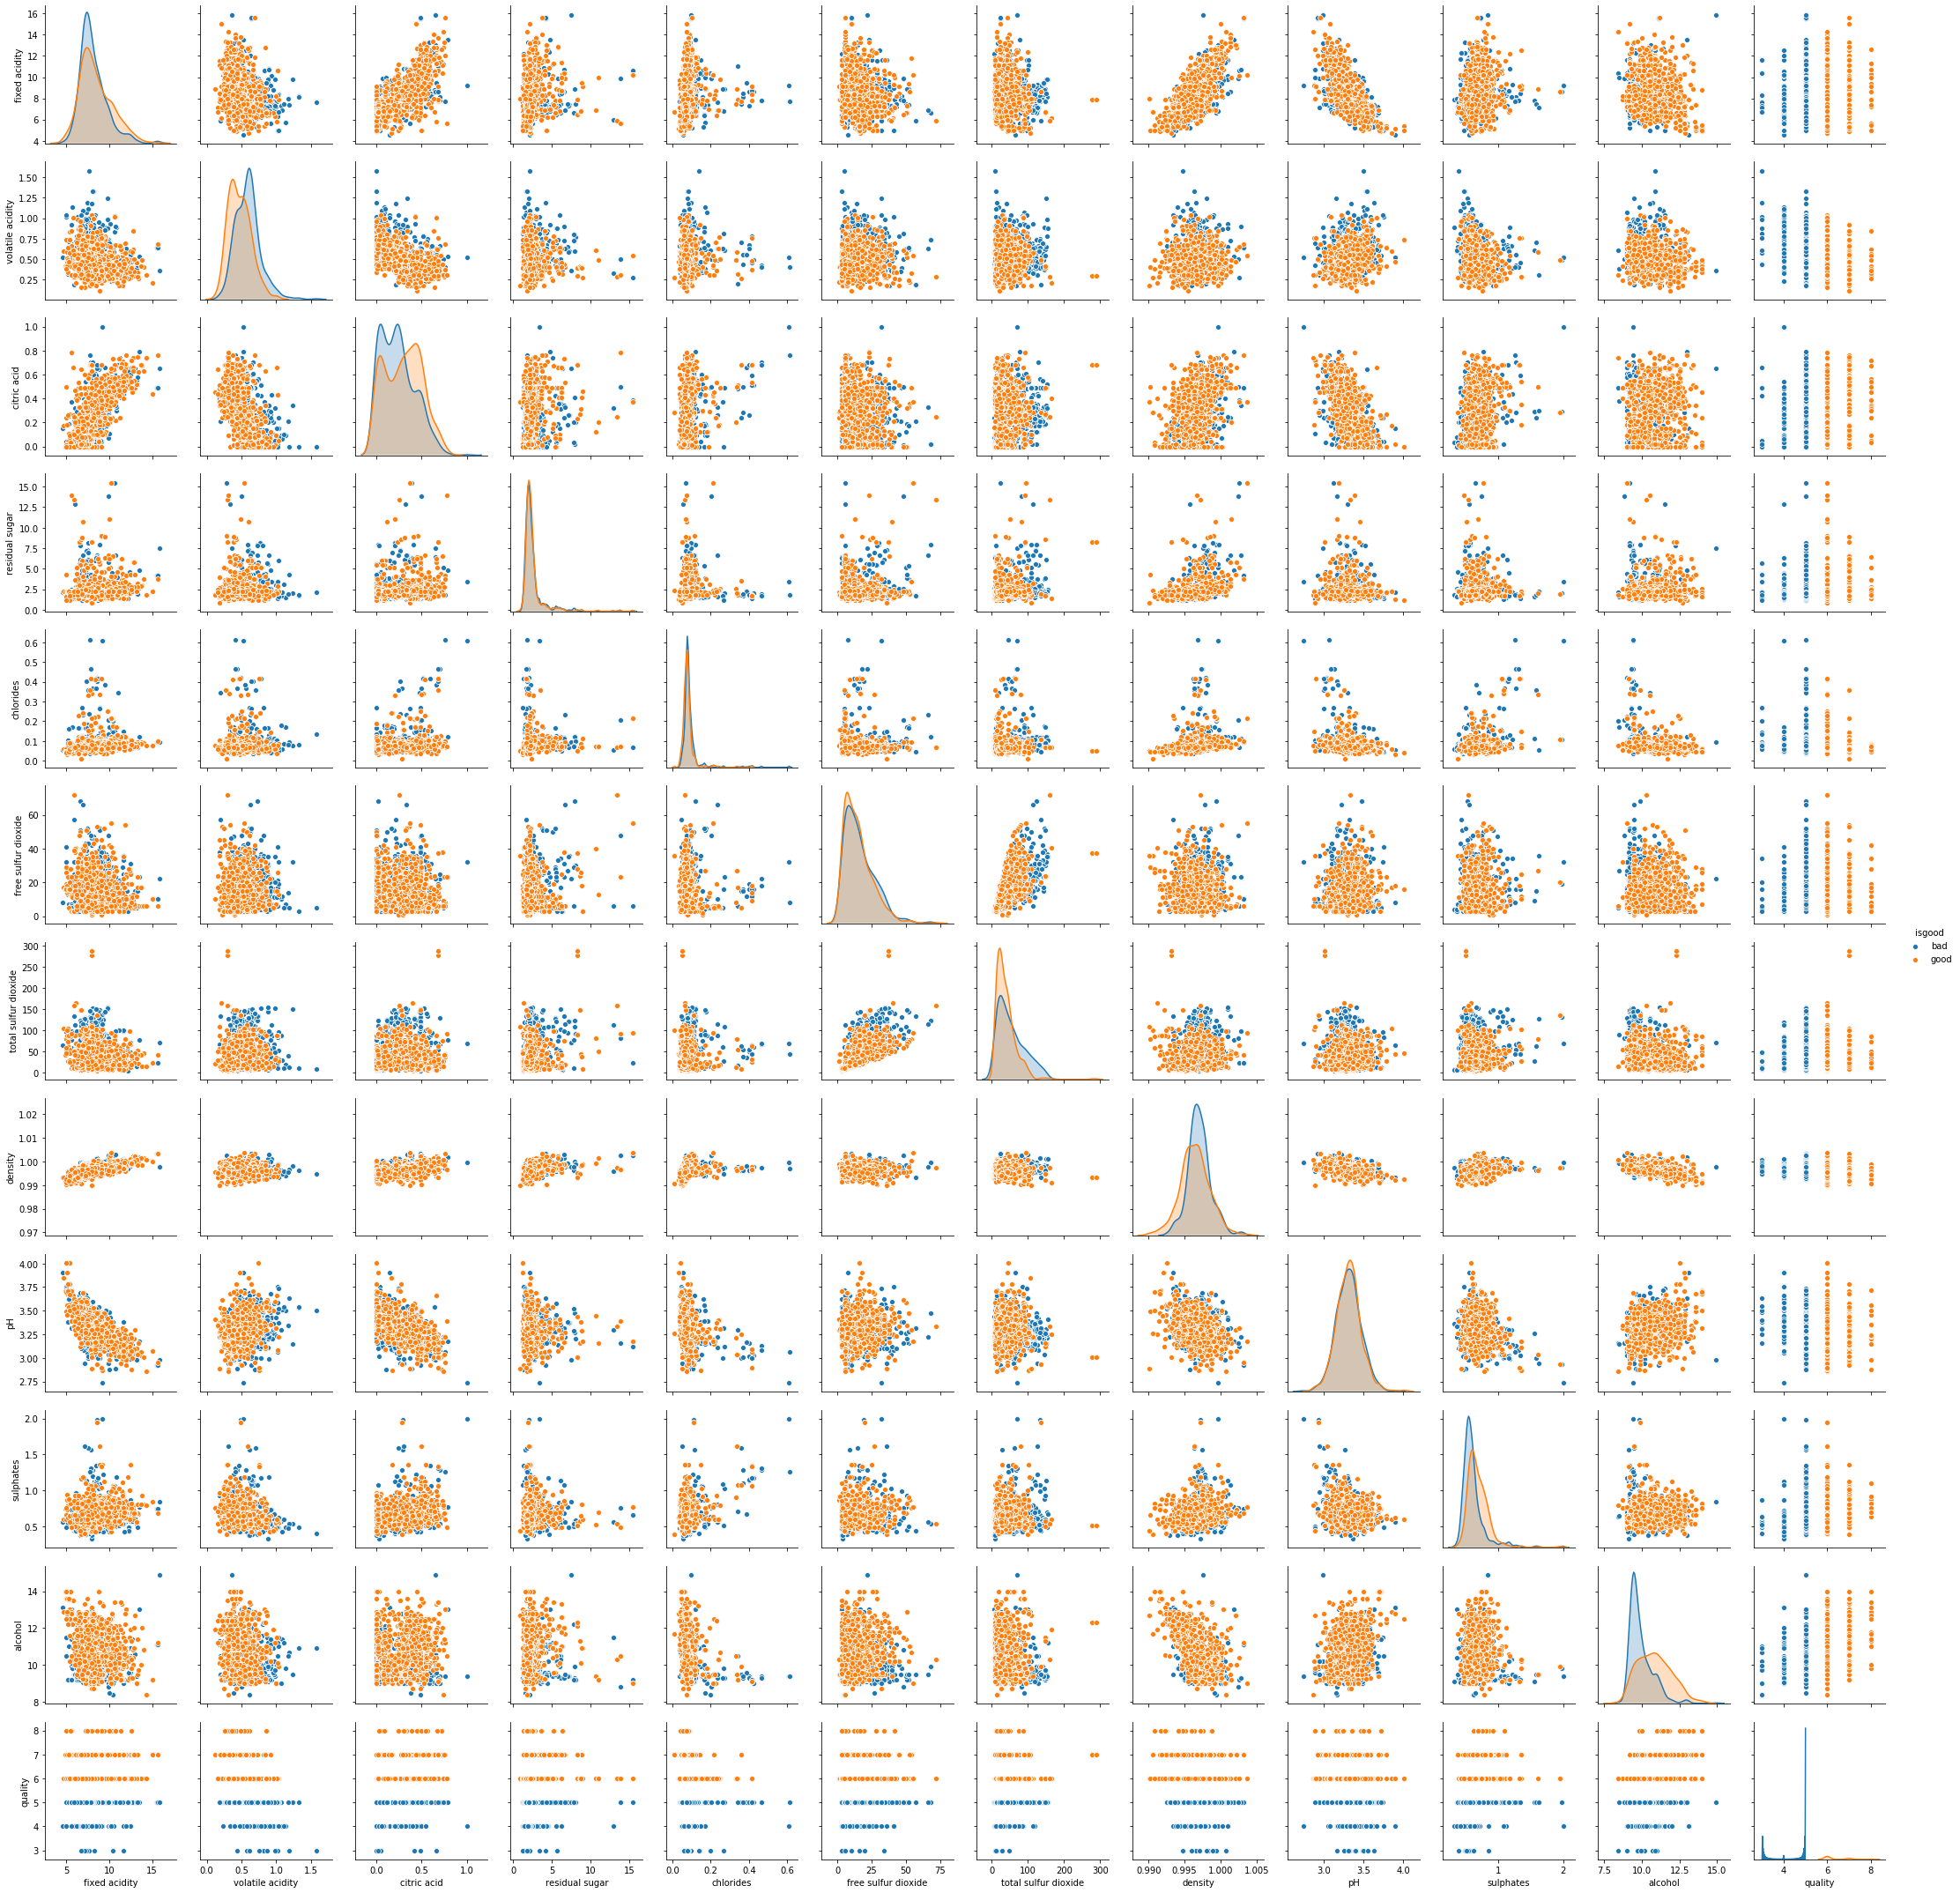

In [57]:
sns.pairplot(wine,hue="isgood")

It can be observed that bad wines and good wines could have very similar distribution or very different distribution patterns in terms of different variables. Especially, in terms of chlorides, free sulfur dioxide and pH, their distribution is nearly exactly same; in terms of volatile acidity and citric acid, the ditribution is overall same, while have slight difference; and in terms of alcohol level and quality, they have completely different distribution patterns. 

### <font color="magenta">Q6: Based on the previous pairplot, for which variables would you expect to see significant differences between good and bad wines?</font>

From alcohol variable and quality variable, I can see significant differences between good and bad wines.
It seems bad wines have low alcohol level while good wines have higher level. And it's obviously that bad alcholes are mostly below or equal quality 5 (most of then have quality 5) while the good wines' quality are more likely above 6 even 8.

## T-test

A t-test is a simple statistical model that's commonly used to test whether the means of two different
distributions are the same.  scipy.stats gives us a handy interface for this:

In [58]:
import scipy.stats as stats

In [59]:
goodwines = wine.query('isgood == "good"')
badwines = wine.query('isgood == "bad"')

In [60]:
stats.ttest_ind(wine[wine.isgood == 'good']['fixed acidity'],wine[wine.isgood == 'bad']['fixed acidity'])

Ttest_indResult(statistic=3.817471367791021, pvalue=0.00013997664808333373)

In [63]:
stats.ttest_ind(wine[wine.isgood == 'good']['fixed acidity'],wine[wine.isgood == 'bad']['fixed acidity'],equal_var=False)
# when you set equal_var False, it's more conservative way, when you not sure your variance

Ttest_indResult(statistic=3.8622483322298358, pvalue=0.0001168399738420885)

tvalue tells 
pvalues tells how likely this different than means will happen by chance.
when pvalue < 0.5, we say it's significantly different.

### <font color="magenta">Q7: Use t-tests to determine whether there are significant differences between good and bad wines for the variables you listed in the previous question.  Are there significant differences?</a>

In [62]:
badwines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,isgood
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,bad
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,bad
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,bad


In [64]:
stats.ttest_ind(wine[wine.isgood == 'good']['pH'],wine[wine.isgood == 'bad']['pH'],equal_var=False)

Ttest_indResult(statistic=-0.13045267817664052, pvalue=0.896225032105741)

In this case, we can say there are significant differences between good and bad wines for fixed acidity, since the p-value < 0.05. But we don't have evidence to show the obvious difference in terms of pH for good wines and bad wines since the pvalue is much larger than 0.05.

### <font color="magenta">Q8: Using the JointGrid approach we used above look at the relationship between sulphates and chlorides.  What patterns do you see?

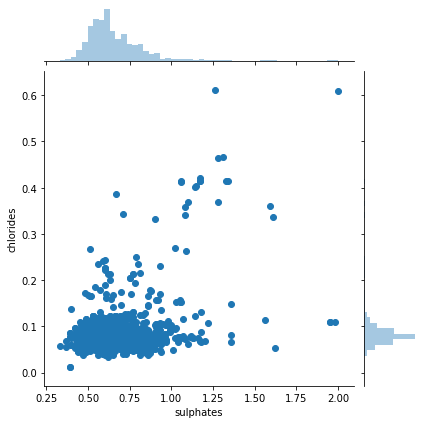

In [75]:
sns.jointplot(data=wine,x='sulphates', y='chlorides')

The wines are more clustered in the group where sulphates are below 1.25 and chlorides are below 0.2. similar information can be drew from the histogram, that both variables have relatively normal ditribution that sulphates has mean value at 0.7 and chlorides has mean value at 0.1. 

## Ordinary Least Squares (OLS) Regression

We can get a lot more detail about the regression model by using statsmodels

In [76]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

statsmodels.formula.api allows you to use R-Style formulas: y ~ x1 + x2 + x3 + ...

1. y represents the outcome/dependent variable
2. x1, x2, x3, etc represent explanatory/independent variables 

In [77]:
model1 = smf.ols('chlorides ~ sulphates', data=wine).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              chlorides   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     255.3
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           1.99e-53
Time:                        10:53:04   Log-Likelihood:                 2737.1
No. Observations:                1599   AIC:                            -5470.
Df Residuals:                    1597   BIC:                            -5459.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0196      0.004      4.475      0.000       0.011       0.028
sulphates      0.1031      0.006     15.978      0.000       0.090       0.116
==============================================================================
Omnibus:                     1419.606   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51655.663
Skew:                           4.079   Prob(JB):                         0.00
Kurtosis:                      29.622   Cond. No.                         8.51
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared: 0.138, only 13.8% variance can be represented by the relationship model.

The likelihood of the relationship between chlorides and sulphates is very samll according to Prob (F-statistic): 1.99e-53.

In [78]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### <font color="magenta">Q9: What is the expected value of chlorides for a wine with a sulphates value of 0.8?</a>

In [79]:
0.8*0.1031 + 0.0196

0.10208

The expected value of chlorides for a wine with a sulphates value of 0.8 is 0.10208. But again, it's not a good model so I wouldn't expect value of chlorides by a given sulphates value. 

### Interesting things happen when we use OLS to do an ANOVA (look closely at the model):

In [80]:
model2 = smf.ols('chlorides ~ C(isgood)', data=wine).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              chlorides   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     19.38
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           1.14e-05
Time:                        11:01:24   Log-Likelihood:                 2628.2
No. Observations:                1599   AIC:                            -5252.
Df Residuals:                    1597   BIC:                            -5242.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0930      0.002     54.200      0.000       0.090       0.096
C(isgood)[T.good]    -0.0103      0.002     -4.402      0.000      -0.015      -0.006
==============================================================================
Omnibus:                     1776.944   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           121109.713
Skew:                           5.649   Prob(JB):                         0.00
Kurtosis:                      44.111   Cond. No.                         2.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
aov_table = sm.stats.anova_lm(model2, typ=2)
print(aov_table)

             sum_sq      df          F    PR(>F)
C(isgood)  0.042438     1.0  19.378659  0.000011
Residual   3.497360  1597.0        NaN       NaN


### We might want to experiment with the original ```quality``` variable, either in a regression model:

In [88]:
wine['quality'].describe()
wine['chlorides'].describe()

count    1599.000000
mean        0.087467
std         0.047065
min         0.012000
25%         0.070000
50%         0.079000
75%         0.090000
max         0.611000
Name: chlorides, dtype: float64

In [82]:
model3 = smf.ols('chlorides ~ quality', data=wine).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              chlorides   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     26.99
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           2.31e-07
Time:                        11:01:29   Log-Likelihood:                 2631.9
No. Observations:                1599   AIC:                            -5260.
Df Residuals:                    1597   BIC:                            -5249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1298      0.008     15.765      0.000       0.114       0.146
quality       -0.0075      0.001     -5.195      0.000      -0.010      -0.005
==============================================================================
Omnibus:                     1776.366   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120907.596
Skew:                           5.646   Prob(JB):                         0.00
Kurtosis:                      44.076   Cond. No.                         41.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### or in an ANOVA (again, look closely at the model):

In [83]:
model4 = smf.ols('chlorides ~ C(quality)', data=wine).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              chlorides   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.036
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           1.53e-05
Time:                        11:01:33   Log-Likelihood:                 2633.5
No. Observations:                1599   AIC:                            -5255.
Df Residuals:                    1593   BIC:                            -5223.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1225      0.015      8.295      0.000       0.094       0.151
C(quality)[T.4]    -0.0318      0.016     -1.976      0.048      -0.063      -0.000
C(quality)[T.5]    -0.0298      0.015     -2.001      0.046      -0.059      -0.001
C(quality)[T.6]    -0.0375      0.015     -2.523      0.012      -0.067      -0.008
C(quality)[T.7]    -0.0459      0.015     -3.034      0.002      -0.076      -0.016
C(quality)[T.8]    -0.0541      0.018     -2.935      0.003      -0.090      -0.018
==============================================================================
Omnibus:                     1784.926   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124552.412
Skew:                           5.683   Prob(JB):                         0.00
Kurtosis:                      44.717   Cond. No.                         36.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
aov_table = sm.stats.anova_lm(model4, typ=2)
print(aov_table)
# statistically different with means coz Prob (F-statistic): 1.53e-05.

              sum_sq      df         F    PR(>F)
C(quality)  0.065812     5.0  6.035639  0.000015
Residual    3.473986  1593.0       NaN       NaN


## Part 3:  Airplane Crashes and Fatalities
The next dataset we are going to look at is the full history of airplane crashes throughout the world, from 1908-2009.  It's taken from:

https://opendata.socrata.com/Government/Airplane-Crashes-and-Fatalities-Since-1908/q2te-8cvq

In [85]:
import pandas as pd
import seaborn as sns

We've provided the CSV file for this lab so you can go ahead and load it in the usual way:

In [86]:
crashes = pd.read_csv('data/Airplane_Crashes_and_Fatalities_Since_1908.csv')

As always, you should take a look at the data to get a sense of 
what it's like:

In [87]:
crashes.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


As we mentioned in an earlier class, pandas is really good at helping
us deal with dates.  The 'Date' column in the dataframe contains 
strings that look like dates.  We can use the ```pandas.to_datetime()``` function to convert the strings to an internal datetime object
(see https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html for more details):

In [ ]:
crashes['Date'] = pd.to_datetime(crashes['Date'])

And let's look at the dataframe again.  See any difference?

In [ ]:
crashes.head()

The pandas datetime object makes it easy to extract interesting 
parts of the date or time.  In our case, we're interested in extracting
the year, so we can do that with the following code:

In [ ]:
crashes['year'] = crashes['Date'].dt.year

And, as always, let's look at what we got:

In [ ]:
crashes.year.head()

As part of the final exercise in this class, let's create a 
visualization of the number of Fatalities per year:

In [ ]:
sns.barplot('year','Fatalities',data=crashes)

That doesn't look great, does it?  


## <font color="magenta">Q10: Create a barplot of the number of fatalities per decade and describe the results. 

Go ahead and create a new column called 'decade' 
that represents the decade for each year.  Remember that an integer divide (a.k.a. a floor divide) can be
done with the // operator.

What's the trend in airplane crash fatalities?

In [47]:
# insert your code here

Insert your interpretation here.

If we had time, I would  ask you to explore manipulating various ways in which you can control
the aesthetics of your figures.  See https://seaborn.pydata.org/tutorial/aesthetics.html for additional information.